In [1]:
import numpy as np
import sympy as sy
from sympy.matrices import Matrix, zeros
import functools
from tqdm import tqdm
import sys
sys.path.append('..')
import ugent

@functools.cache
def coeffs(points):
    n = len(points)
    
    A = Matrix(n, n, lambda i, j: points[j]**i)
    b = zeros(n, 1)
    b[2, 0] = 2
    return list(A.LUsolve(b).T.row(0))

for n in tqdm(range(1, 40)):
    coeffs(range(-n,n+1))

100%|████████████████| 39/39 [00:30<00:00,  1.30it/s]


In [2]:
import numpy as np
import scipy.sparse as sps

class FDSchrodinger:
    def __init__(self, V, xbounds, ybounds, nx, ny, mx, my):
        self.cx = np.array(coeffs(range(-mx, mx+1)), dtype="float64")
        self.cy = np.array(coeffs(range(-my, my+1)), dtype="float64")
        self.xs = np.linspace(*xbounds, nx+1)
        self.ys = np.linspace(*ybounds, ny+1)
        X, Y = np.meshgrid(self.xs[1:-1], self.ys[1:-1])
        self.vs = V(X, Y)
        hx = (xbounds[1] - xbounds[0])/nx
        hy = (ybounds[-1] - ybounds[0])/ny
        self.cx /= -hx**2
        self.cy /= -hy**2
    
    def system(self):
        nx = self.xs.shape[0] - 2
        ny = self.ys.shape[0] - 2
        N = nx*ny
        mx = self.cx.shape[0]//2
        my = self.cy.shape[0]//2
        
        B = np.zeros((N, N), dtype="float64")
        for ix in range(nx):
            for iy in range(ny):
                lowx = max(-mx, -ix)
                highx = min(mx + 1, nx - ix)
                B[iy*nx + ix, iy*nx + ix + lowx : iy*nx + ix + highx] += self.cx[mx + lowx : mx + highx]
                
                lowy = max(-my, -iy)
                highy = min(my + 1, ny - iy)
                B[iy*nx + ix, (iy + lowy)*nx + ix : (iy + highy)*nx + ix : nx] += self.cy[my + lowy : my + highy]
        
        B += np.diag(self.vs.flatten())
        
        return B
    
    def solve(self, k=20):
        return np.array(sorted(sps.linalg.eigsh(sps.csr_matrix(
            self.system()), which='SA', k=k, return_eigenvectors=False)))

In [3]:
from p_tqdm import p_map

    
def test_problem(settings):
    exact = settings["exact"]
        
    def single_solve(params):
        n, m = params
        fds = FDSchrodinger(**settings['problem'], nx=n, ny=n, mx=m, my=m)
        return params, np.abs((fds.solve(len(exact)) - exact)/exact)

    parameters = settings["parameters"]
    results = dict(p_map(single_solve, parameters))
    
    results_by_n = {}
    results_by_m = {}
    for (n,m), r in results.items():
        if n not in results_by_n:
            results_by_n[n] = {}
        if m not in results_by_m:
            results_by_m[m] = {}

        results_by_n[n][m] = r
        results_by_m[m][n] = r
    
    return results_by_n, results_by_m

In [4]:
settings = {
    "exact": np.array([2*i for i in range(1, 30) for k in range(i)][:101]),
    "multiplicities": [i for i in range(1, 30)],
    "problem": {
        "V": lambda x, y:  x*x + y*y,
        "xbounds": (-9.5, 9.5),
        "ybounds": (-9.5, 9.5),
    },
    "parameters": [
        (n, m) for n in [20, 30, 40, 50, 60, 70, 80, 90, 100] for m in [5, 10, 15, 20]
    ]
}

results_by_n, results_by_m = test_problem(settings)

  0%|          | 0/36 [00:00<?, ?it/s]

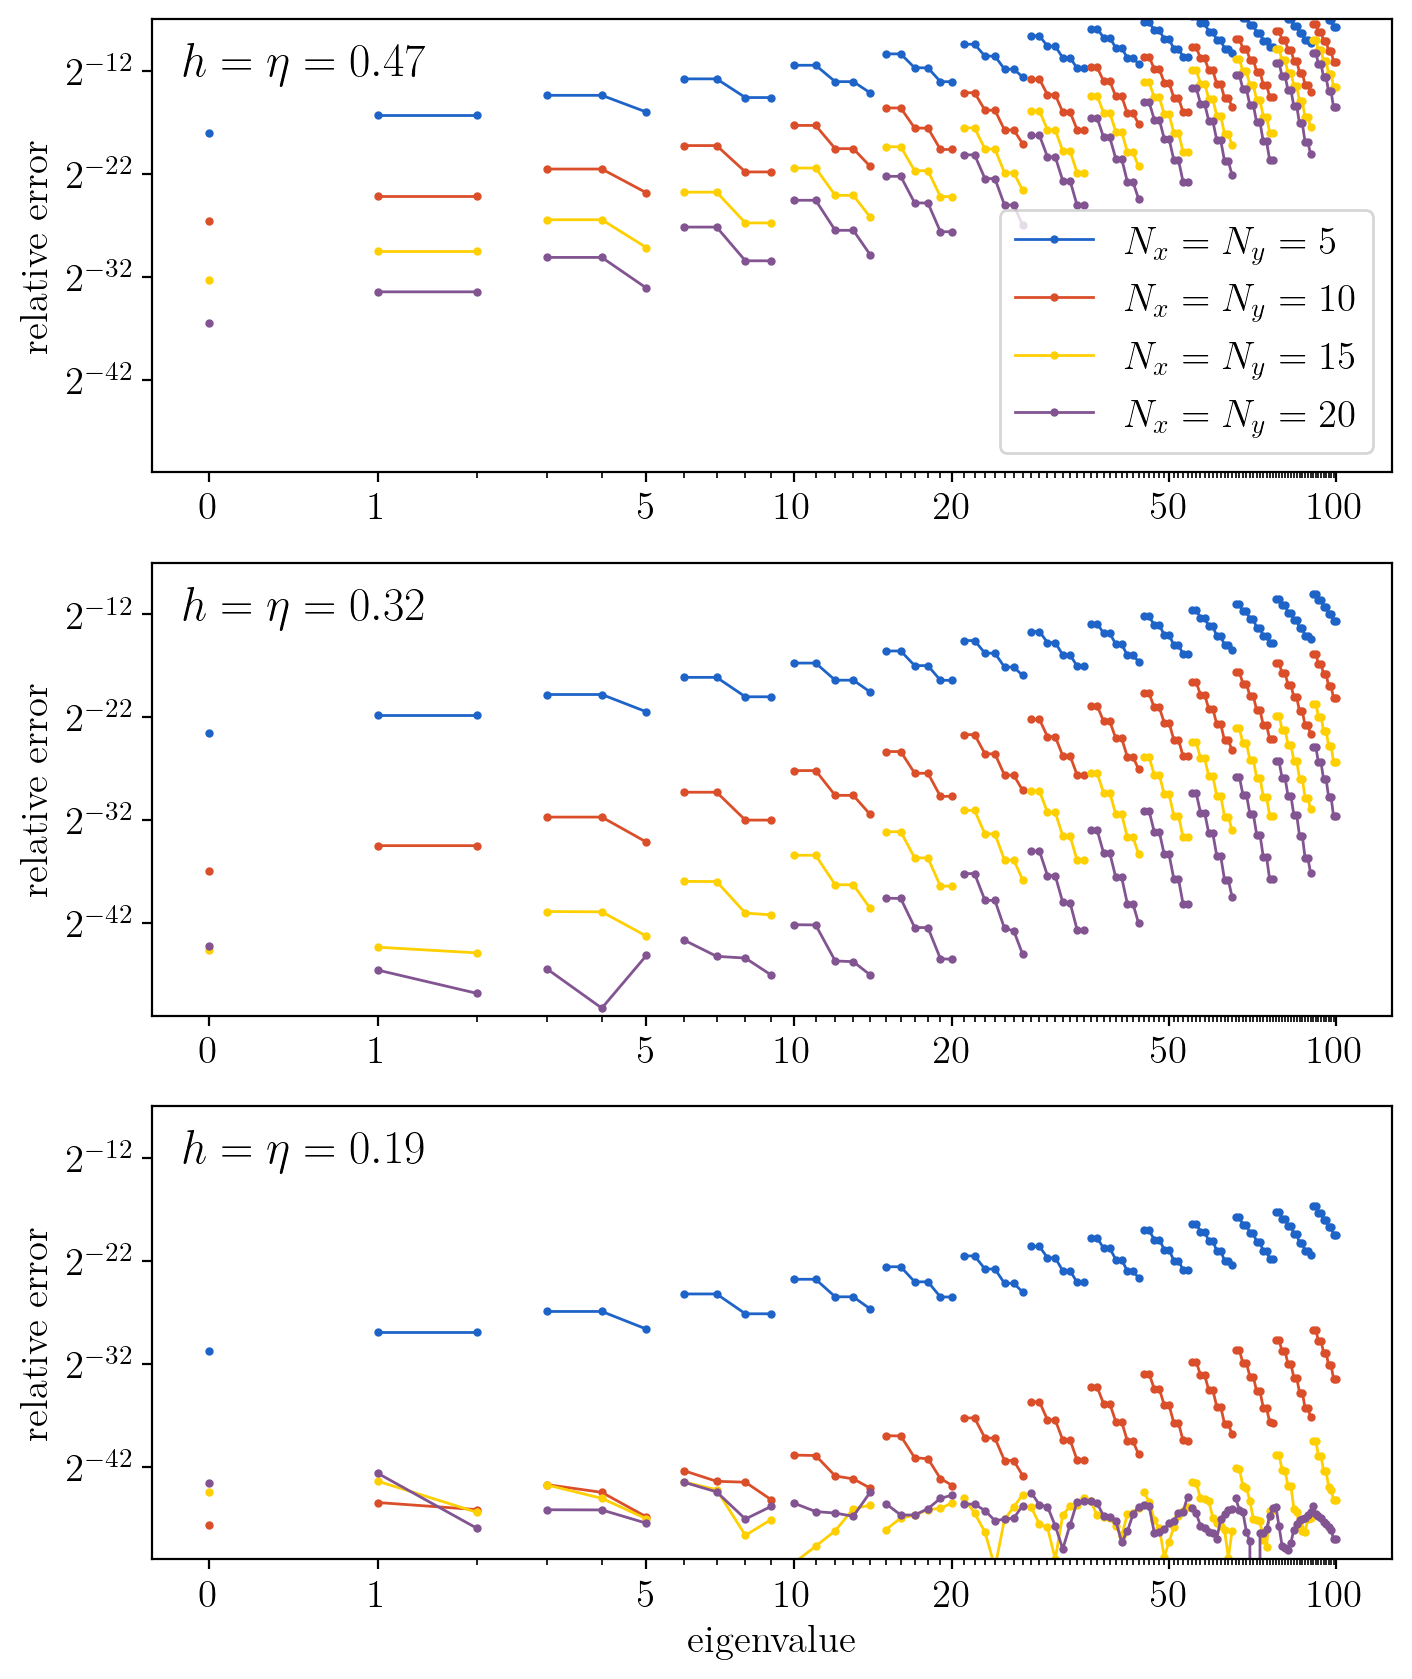

In [5]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FormatStrFormatter, ScalarFormatter


fig, axes = plt.subplots(3, 1, figsize=(8, 10), dpi=200)
    
for ni, n in enumerate([40, 60, 100]):
    rm = results_by_n[n]
    N = len(next(iter(rm.values())))

    ax = axes[ni]
    ax.set_xscale('log', base=10)
    ax.set_yscale('log', base=2)
    xticks = [1, 2, 6, 11, 21, 51, 101]
    ax.set_xticks(xticks, labels=[f"{x-1}" for x in xticks])
    ax.set_xticks(range(1, 101), labels=[], minor=True)
    ax.set_ylim(2**-51, 2**-7)
    ax.set_ylabel("relative error")
    if ni == 2:
        ax.set_xlabel("eigenvalue")

    mults = settings["multiplicities"]

    for i, (m, r) in enumerate(sorted(rm.items())):
        j = 0

        kwargs = dict(
            label=f"$N_x=N_y={m}$",
            color=ugent.palet[i],
            marker='.', ls='-', lw=1, markersize=4,
        )
        for mult in mults:
            d = r[j:j+mult]
            ax.plot(range(j + 1, j+len(d)+1), d, **kwargs)
            if j == 0:
                del kwargs["label"]
            j += mult
            if j >= len(r):
                break

    ax.set_title(f"$h = \\eta = {19/n:.2f}$", y=0.835, x=0.025, loc="left")
    if ni == 0:
        ax.legend()
fig.show()
plt.savefig(f"fd_harmonic.pdf", bbox_inches="tight")

In [8]:
from scipy.optimize import least_squares
from math import log, pi

orders = []
for m in [5, 10, 15, 20]:
    def order(x):
        a, eh, ek = x

        err = []
        rn = sorted(results_by_m[m].items())
        if m == 20:
            rn = rn[:-2]
        for n, r in rn:
            for k, v in list(enumerate(r))[30:]:
                if v > 0:
                    err.append(log(v) - (a  + log(1/n)*eh + log(1+k)*ek))
        return err

    ls = least_squares(order, [1, 10, 2])
    a, eh, ek = ls.x
    print(m, ls.x)
    orders.append((m, (eh, ek)))
    
ms, es = zip(*orders)

with open("fd_harmonic_orders.tex", 'w') as f:
    print(f"\\begin{{tabular}}{{r|{'c'*len(ms)}}}", file=f)
    s = "$N_x = N_y$"
    for m in ms:
        s += f" & ${m}$"
    
    print(s + r" \\\hline\rule{0pt}{2.6ex}", file=f)
    
    s = "Error"
    for eh, ek in es:
        s += f" & $\\OO\\mleft(h^{{\\numprint{{{eh:.2f}}}}}k^{{\\numprint{{{ek:.2f}}}}}\\mright)$"
    print(s, file=f)
    print(r"\end{tabular}", file=f)

5 [12.83944439  7.58560366  2.09885657]
10 [27.68618803 13.99738539  3.38231879]
15 [43.12533548 19.49526852  3.9116006 ]
20 [48.99651261 21.96454421  4.23462784]


In [9]:
fds = FDSchrodinger(lambda x, y: 0*x, (0, pi), (0, pi), 80, 80, 1, 1)
fds.solve()

array([ 1.99974299,  4.99781575,  4.99781575,  7.99588851,  9.98946696,
        9.98946696, 12.98753972, 12.98753972, 16.96699986, 16.96699986,
       17.97919093, 19.96507262, 19.96507262, 24.95672383, 24.95672383,
       25.9196556 , 25.9196556 , 28.91772836, 28.91772836, 31.93425673])

In [6]:
from math import pi
from itertools import groupby

exact = sorted([i*i + j*j for i in range(1, 100) for j in range(1, 100)])[:101]

settings_zero = {
    "exact": exact,
    "multiplicities": [sum(1 for _ in l) for _, l in groupby(exact)],
    "problem": {
        "V": lambda x, y: 0*x,
        "xbounds": (0, pi),
        "ybounds": (0, pi),
    },
    "parameters": [
        (n, m) for n in [25, 50, 100] for m in [1, 2, 5]
    ]
}

results_zero_by_n, results_zero_by_m = test_problem(settings_zero)

  0%|          | 0/9 [00:00<?, ?it/s]

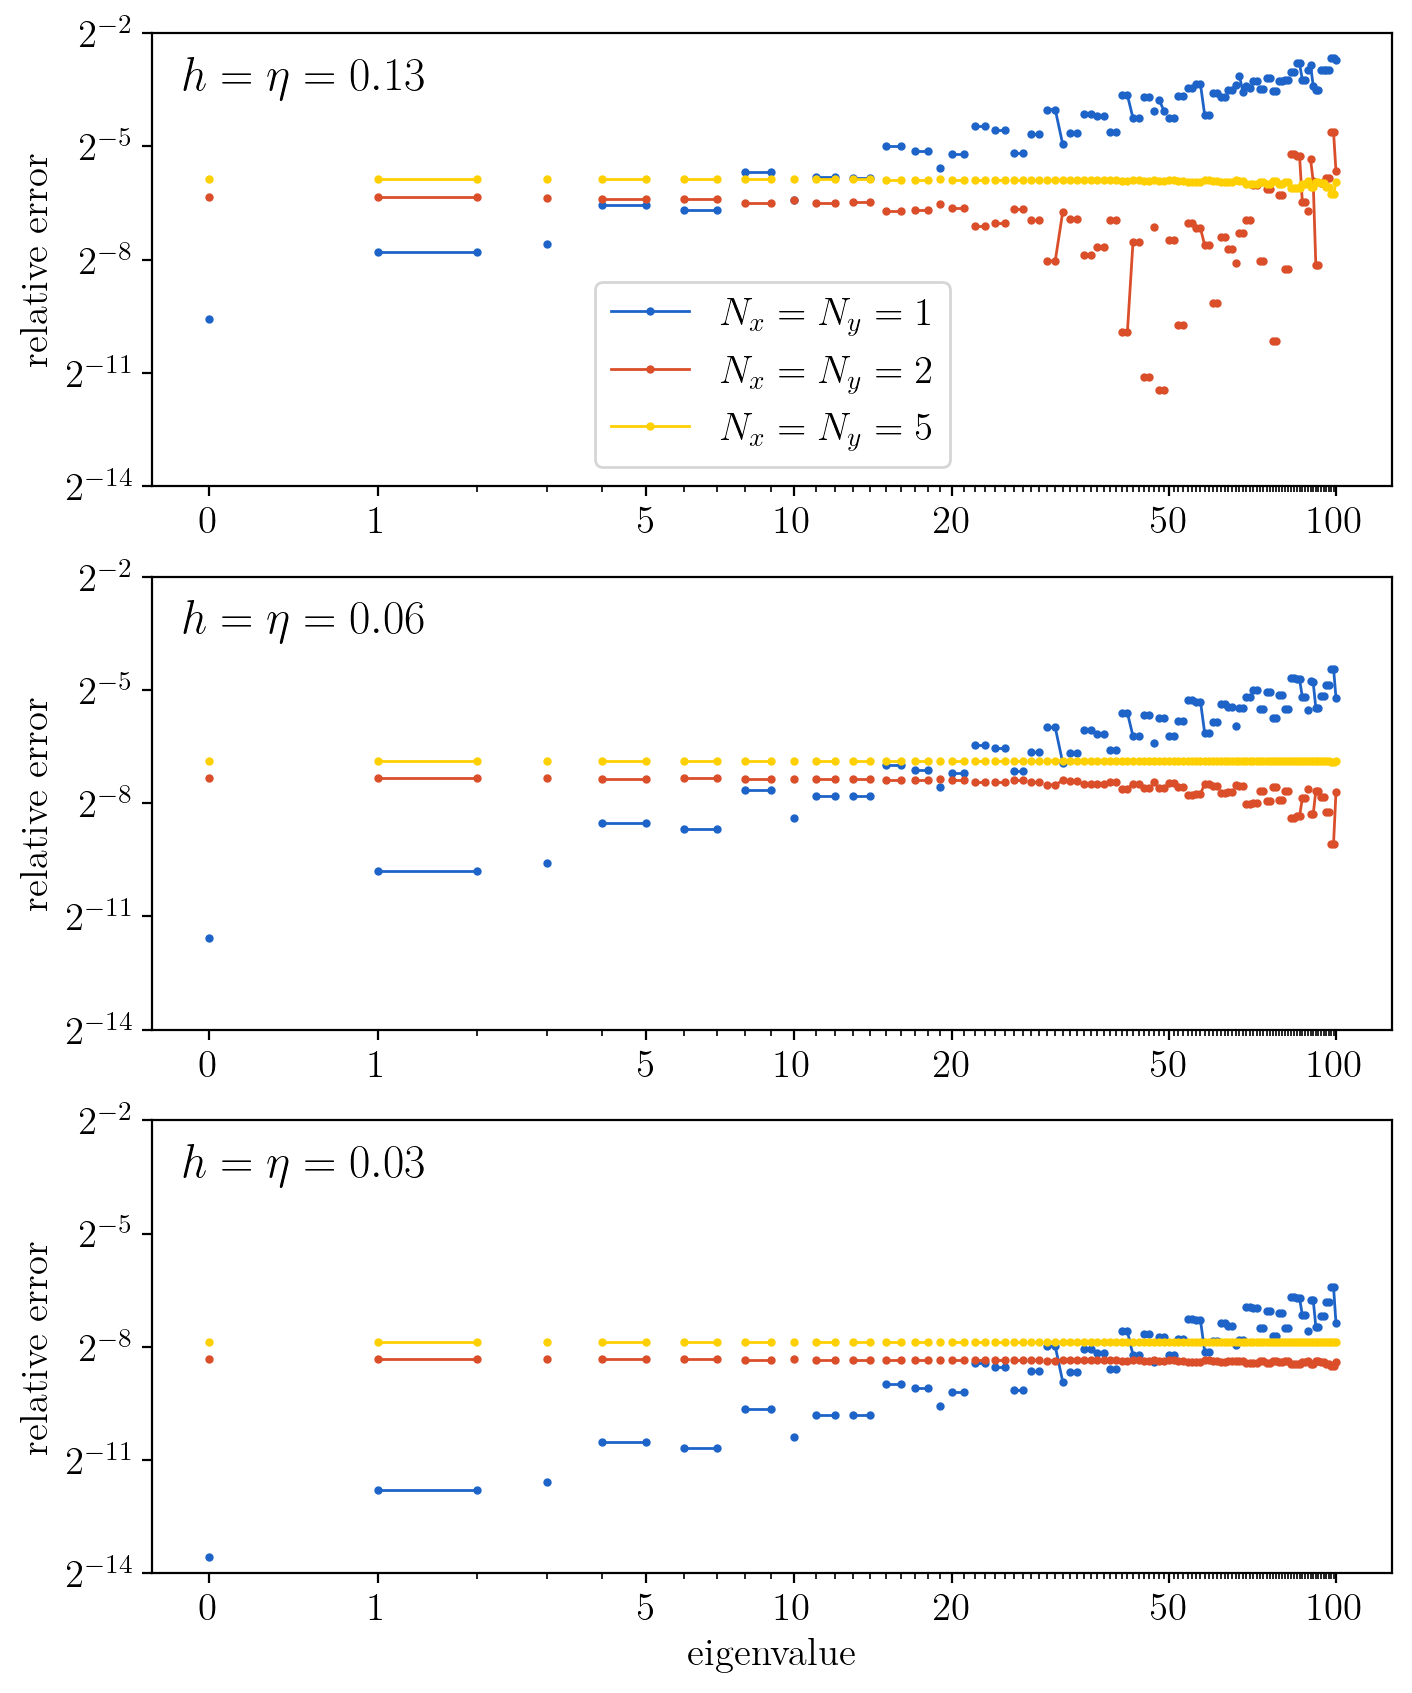

In [7]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FormatStrFormatter, ScalarFormatter


fig, axes = plt.subplots(3, 1, figsize=(8, 10), dpi=200)
    
for ni, n in enumerate([25, 50, 100]):
    rm = results_zero_by_n[n]
    N = len(next(iter(rm.values())))

    ax = axes[ni]
    ax.set_xscale('log', base=10)
    ax.set_yscale('log', base=2)
    xticks = [1, 2, 6, 11, 21, 51, 101]
    ax.set_xticks(xticks, labels=[f"{x-1}" for x in xticks])
    ax.set_xticks(range(1, 101), labels=[], minor=True)
    ax.set_ylim(2**-14, 2**-2)
    ax.set_ylabel("relative error")
    if ni == 2:
        ax.set_xlabel("eigenvalue")

    mults = settings_zero["multiplicities"]

    for i, (m, r) in enumerate(sorted(rm.items())):
        j = 0

        kwargs = dict(
            label=f"$N_x=N_y={m}$",
            color=ugent.palet[i],
            marker='.', ls='-', lw=1, markersize=4,
        )
        for mult in mults:
            d = r[j:j+mult]
            ax.plot(range(j + 1, j+len(d)+1), d, **kwargs)
            if j == 0:
                del kwargs["label"]
            j += mult
            if j >= len(r):
                break

    ax.set_title(f"$h = \\eta = {pi/n:.2f}$", y=0.835, x=0.025, loc="left")
    if ni == 0:
        ax.legend()
fig.show()
plt.savefig(f"fd_zero.pdf", bbox_inches="tight")

In [15]:
from schrodinger import Schrodinger2D, Rectangle

s = Schrodinger2D(lambda x, y: 0, Rectangle(0, pi, 0, pi))
s.eigenvalues(10)

[2.000000000001303,
 4.999999999999259,
 5.00000000000064,
 8.000000000002723,
 9.99999999999937,
 10.000000000000776,
 12.999999999998886,
 12.99999999999959,
 16.999999999999062,
 17.0000000000008]

In [55]:
rows = 6
cols = 3

n = rows*cols
d = {}
for v, (i, j) in sorted([(i*i+j*j, (i, j)) for i in range(1, n+1) for j in range(1, n+1)]):
    if v not in d:
        d[v] = []
    d[v].append((i, j))
    
out = [[""]*cols for _ in range(rows)]
for k, (v, ijs) in enumerate(d.items()):
    if k >= n:
        break
    out[k%rows][k//rows] = ' = '.join(f"\\lambda_{{{i},{j}}}" for i, j in ijs) + f" &= {v}"
print('\\\\\n'.join(map(' & '.join, out)))

\lambda_{1,1} &= 2 & \lambda_{3,3} &= 18 & \lambda_{3,5} = \lambda_{5,3} &= 34\\
\lambda_{1,2} = \lambda_{2,1} &= 5 & \lambda_{2,4} = \lambda_{4,2} &= 20 & \lambda_{1,6} = \lambda_{6,1} &= 37\\
\lambda_{2,2} &= 8 & \lambda_{3,4} = \lambda_{4,3} &= 25 & \lambda_{2,6} = \lambda_{6,2} &= 40\\
\lambda_{1,3} = \lambda_{3,1} &= 10 & \lambda_{1,5} = \lambda_{5,1} &= 26 & \lambda_{4,5} = \lambda_{5,4} &= 41\\
\lambda_{2,3} = \lambda_{3,2} &= 13 & \lambda_{2,5} = \lambda_{5,2} &= 29 & \lambda_{3,6} = \lambda_{6,3} &= 45\\
\lambda_{1,4} = \lambda_{4,1} &= 17 & \lambda_{4,4} &= 32 & \lambda_{1,7} = \lambda_{5,5} = \lambda_{7,1} &= 50


In [3]:
fds = FDSchrodinger(lambda x, y: (x*x+1)*(y*y+1), (-5.5,5.5), (-5.5,5.5), 70,70,30,30)

In [5]:
list(fds.solve(50))

[3.1959180852002875,
 5.526743874395892,
 5.52674387439598,
 7.5578033268115705,
 8.031272340354867,
 8.444581361570142,
 9.928061057527405,
 9.928061057527698,
 11.311817050818108,
 11.311817050818135,
 12.103253587043476,
 12.201178977951638,
 13.332331271164326,
 14.348268636441496,
 14.348268636441507,
 14.450478722004934,
 14.58055632766992,
 16.151419233222096,
 16.15141923322227,
 16.5171933681111,
 16.564872847828678,
 17.894578649162888,
 17.894578649163105,
 18.58339173682187,
 18.756210428990627,
 18.7562104289909,
 18.976194437644192,
 19.594476552720455,
 20.735799751101748,
 20.92020084025792,
 21.293112025929858,
 21.29311202593029,
 21.512217863843887,
 21.644290400062875,
 22.61644518758066,
 22.616445187580677,
 23.216883367193034,
 23.216883367193283,
 23.753167985016958,
 23.926307142759327,
 24.88740887314453,
 25.020642722472815,
 25.20272411845297,
 25.20272411845327,
 25.603186276904548,
 26.325640380353697,
 26.392754991514447,
 26.392754991514636,
 26.44384649